# Get Ridge Line

## Import libraries

In [1]:
import astropy
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
import sys
import matplotlib.pyplot as plt
from matplotlib import rc_params_from_file
from pathlib import Path
import copy
from types import NoneType
import os
import re

rc_file = "./matplotlibrc"
plt.rcParams.update(rc_params_from_file(rc_file))

%matplotlib inline

## Set parameters to work with

In [2]:
object_name = "melotte66"
path_to_data = "/home/gunzfox/Scripts/Astro/astrogaia-python/Objects"
#file_containing_data = f"{path_to_data}/OpenCluster/{object_name.lower()}/{object_name.lower()}_filter_cordoni.dat"
file_containing_data = f"{path_to_data}/OpenCluster/{object_name.lower()}/{object_name.lower()}_data_to_ridge_line.dat"
format_to_read_data = "ascii.ecsv"
parameter_magnitude = "phot_bp_mean_mag"
parameter_color = "bp_rp"
n_divisions_ridge_line = 50
Sigma = 2.5
n_iteration_steps = 6
file_to_write_results = "../astrogaia-python/Objects/OpenCluster/MSTO_OpenClusters.dat"

## Get preliminary ridge line itself and clean it

In [3]:
@dataclass(kw_only=True, frozen=True)
class classBin:
    ID: int
    min_mag: float
    max_mag: float
    median_mag_value: float
    std_magnitude: float
    median_color_value: float
    std_color: float
        

def get_max_and_min_from_data(data: Table, parameter: str) -> (float, float):
    """
    Given a set of a data, extract the max and min from a row (parameter)
    """
    try:
        min_value = np.amin(data[parameter])
        max_value = np.amax(data[parameter])
    except KeyError:
        print(f"You have provided an invalid parameter to extract data: {parameter!r}")
        sys.exit(1)
    return min_value, max_value


def build_bins(data: Table, parameter_mag: str, parameter_color: str,
               n_divisions: int = n_divisions_ridge_line) -> list[classBin] | None:
    """
    Given a data with a maximum and a minimum values for a parameter, divide de data into bins
    computing their std dev and median
    """
    print("[*] Building bins...")
    if n_divisions == 0:
        print("You cannot divide by 0 bins")
        sys.exit(1)
    minimum_value, maximum_value = get_max_and_min_from_data(data, parameter_mag)
    difference: float = maximum_value - minimum_value
    length_bin: float = difference/(n_divisions*1.0)
    bins_list = []
    for n in range(0, n_divisions):
        temp_magnitude_data = []
        temp_color_data = []
        min_value_bin = minimum_value + (n * length_bin)
        max_value_bin = minimum_value + ( (n+1) * length_bin)
        for data_it in data:
            if min_value_bin < data_it[parameter_mag] < max_value_bin:
                temp_magnitude_data.append(data_it[parameter_mag])
                temp_color_data.append(data_it[parameter_color])
                continue
        if len(temp_magnitude_data) >= 2:
            std_data_color: float = np.std(temp_color_data, ddof=1)
            std_data_magnitude: float = np.std(temp_magnitude_data, ddof=1)
        else:
            std_data_color: float = np.std(temp_color_data)
            std_data_magnitude: float = np.std(temp_magnitude_data)
        median_data_color: float = np.median(temp_color_data)
        median_data_mag: float = np.median(temp_magnitude_data)
        created_bin = classBin(ID=n+1, min_mag=min_value_bin, max_mag=max_value_bin,
                               median_mag_value=median_data_mag, 
                               std_magnitude=std_data_magnitude, median_color_value=median_data_color, 
                               std_color=std_data_color)
        bins_list.append(created_bin)
    print(f"[+] Bins created: {len(bins_list)}")
    return bins_list


def clean_bins(data: Table, parameter_mag: str, parameter_color: str,
               bin_list: list[classBin], sigma=Sigma) -> Table | None:
    """
    Clean data bins generated
    """
    mask_array = []
    print("[*] Cleaning bins...")
    if len(bin_list) == 0:
        print("[!] Bin list size cannot be 0")
        sys.exit(1)
    for data_it in data:
        for bin_it in bin_list:
            condition1 = bin_it.min_mag <= data_it[parameter_mag] <= bin_it.max_mag
            condition2 = bin_it.median_color_value - sigma*bin_it.std_color <= data_it[parameter_color] <= bin_it.median_color_value + sigma*bin_it.std_color
            if condition1:
                if condition2:
                    mask_array.append(True)
                else:
                    mask_array.append(False)
                break
    if len(data) != len(mask_array):
        print("[!] Warning. Data length and mask length do not match")
        print(f"    Data length: {len(data)}")
        print(f"    Mask length: {len(mask_array)}")
        sys.exit(1)
    mask_array = np.asarray(mask_array)
    print("[*] Bins cleaned")
    return data[mask_array]

   
original_data = Table.read(file_containing_data, format=format_to_read_data)  
original_data.pprint(max_lines=5, max_width=120)
bins_list = build_bins(original_data, parameter_magnitude, parameter_color)
data_cleaned = clean_bins(original_data, "phot_bp_mean_mag", "bp_rp", bins_list)

    solution_id              DESIGNATION                source_id      ... libname_gspphot          dist         
                                                                       ...                                       
------------------- ------------------------------ ------------------- ... --------------- ----------------------
1636148068921376768 "Gaia DR3 5507234463979333632" 5507234463979333632 ...         "MARCS" 0.00041319987172952835
                ...                            ...                 ... ...             ...                    ...
1636148068921376768 "Gaia DR3 5507210854540180352" 5507210854540180352 ...         "MARCS"    0.16614811032453805
1636148068921376768 "Gaia DR3 5507215596184288512" 5507215596184288512 ...         "MARCS"    0.16626919153630754
Length = 843 rows
[*] Building bins...
[+] Bins created: 50
[*] Cleaning bins...
[*] Bins cleaned


## Set some paths to save data

In [4]:
path_file = Path(file_containing_data)
path_to_save_data = str(path_file.parent)
print(f"[+] Data and plots will be saved in {path_to_save_data!r}")
save_format = "png"
n_dpi = 300

[+] Data and plots will be saved in '/home/gunzfox/Scripts/Astro/astrogaia-python/Objects/OpenCluster/melotte66'


## Plot the first ridge line obtained

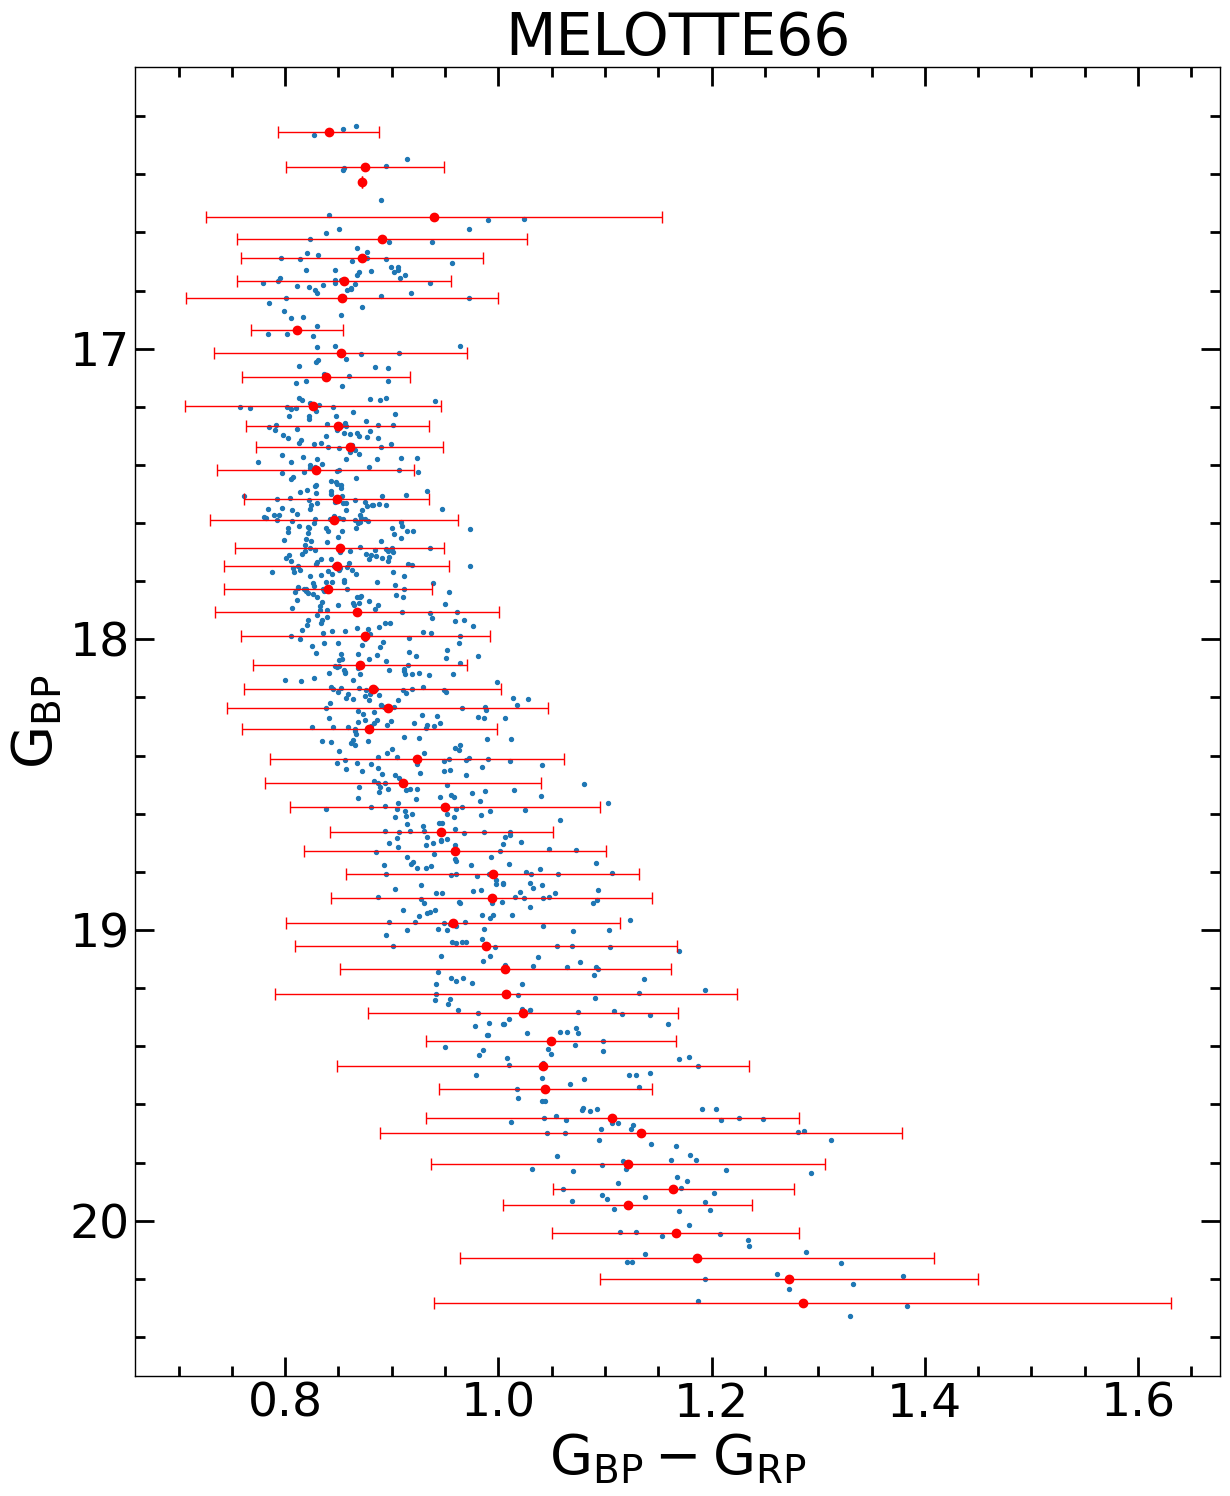

In [5]:
def plot_original_bins_in_CMD(original_data_plot: Table, param_color: str, param_magnitude: str,
                             bins_list_plot: list[classBin], doSaveimage: bool = True) -> None:
    # Extract the parameters to get the Ridge Line
    colors = [bin_it.median_color_value for bin_it in bins_list_plot]
    err_colors = [Sigma*bin_it.std_color for bin_it in bins_list_plot]
    mags = [bin_it.median_mag_value for bin_it in bins_list_plot]
    # Set the parameters to plot    
    font_sizes = 40
    plt.figure(figsize=(14, 17))
    plt.gca().invert_yaxis()
    plt.scatter(original_data_plot[param_color], original_data_plot[param_magnitude], s = 8.)
    plt.errorbar(colors, mags, xerr=err_colors, fmt='o', color = "red", capsize=4, markersize=6)
    plt.xlabel(r"${\rm G}_{\rm BP} - {\rm G}_{\rm RP}$", fontsize=font_sizes)
    plt.ylabel(r"${\rm G}_{\rm BP}$", fontsize = font_sizes)
    plt.title(object_name.upper(), fontsize = font_sizes+2)
    plt.xticks(fontsize=font_sizes - 6)
    plt.yticks(fontsize=font_sizes - 6)
    # Add text annotation at the top right corner
    plt.tick_params(axis='both', which='major', length=14, width=2)
    plt.tick_params(axis='both', which='minor', length=7, width=2)
    if doSaveimage:
        plt.savefig(f"{path_to_save_data}/{object_name.lower()}_ridge_line_pre_iter.{save_format}", format=save_format, dpi=n_dpi)
    plt.show()
    plt.close()
    
plot_original_bins_in_CMD(original_data, "bp_rp", "phot_bp_mean_mag", bins_list)
    


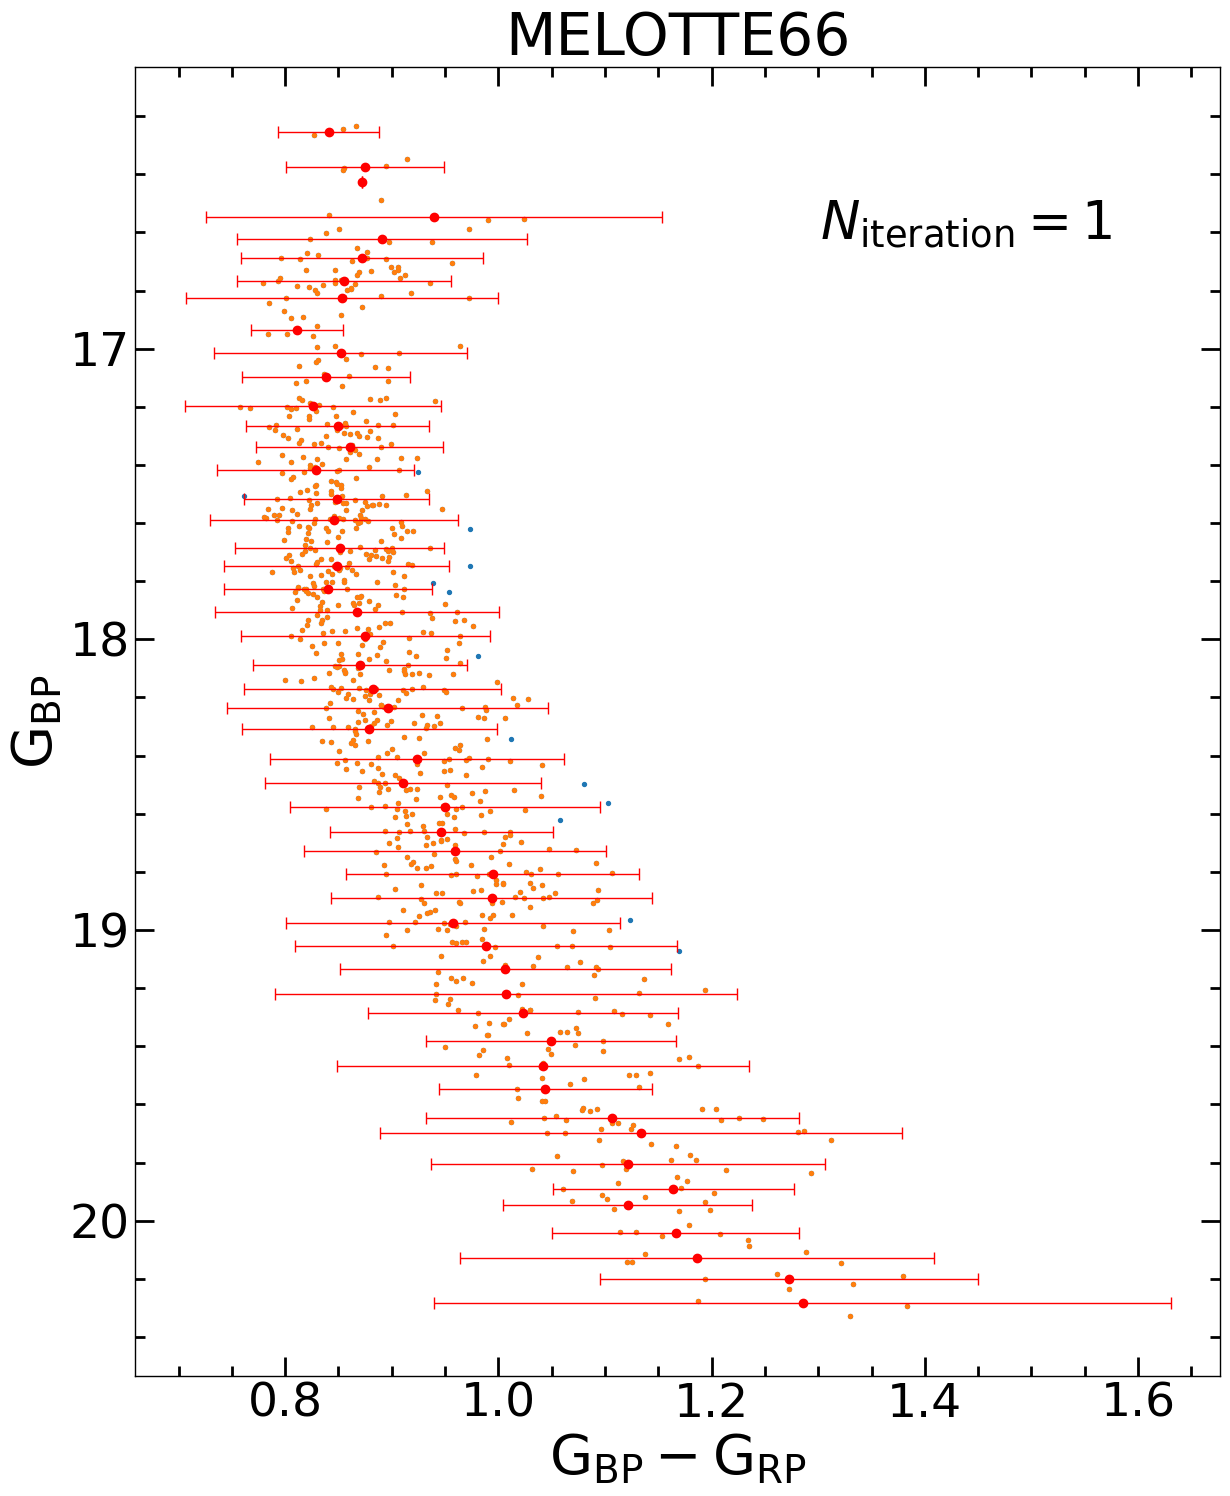

In [6]:
def plot_cleaned_ridge_line(pre_cleaned_data_plot: Table, cleaned_data_plot: Table, 
                            param_color: str, param_mag: str, bins_list_plot: list[classBin], 
                            current_n_iteration: int, doSaveImage: bool = True) -> None:
    # Extract the parameters to get the Ridge Line
    colors = [bin_it.median_color_value for bin_it in bins_list_plot]
    err_colors = [Sigma*bin_it.std_color for bin_it in bins_list_plot]
    mags = [bin_it.median_mag_value for bin_it in bins_list_plot]

    # Set the parameters to plot
    font_sizes = 40
    plt.figure(figsize=(14, 17))
    plt.gca().invert_yaxis()
    plt.scatter(pre_cleaned_data_plot[parameter_color], pre_cleaned_data_plot[parameter_magnitude], s = 8.)
    plt.scatter(cleaned_data_plot[parameter_color], cleaned_data_plot[parameter_magnitude], s= 8.)
    plt.errorbar(colors, mags, xerr=err_colors, fmt='o', color = "red", capsize=4, markersize=6)
    plt.xlabel(r"${\rm G}_{\rm BP} - {\rm G}_{\rm RP}$", fontsize=font_sizes)
    plt.ylabel(r"${\rm G}_{\rm BP}$", fontsize = font_sizes)
    plt.title(object_name.upper(), fontsize = font_sizes+2)
    plt.xticks(fontsize=font_sizes - 6)
    plt.yticks(fontsize=font_sizes - 6)
    # Add text annotation at the top right corner
    plt.text(0.9, 0.9, r'$N_{\rm iteration} = $'+str(current_n_iteration), fontsize=font_sizes -2, ha='right', va='top', transform=plt.gca().transAxes, bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))
    plt.tick_params(axis='both', which='major', length=14, width=2)
    plt.tick_params(axis='both', which='minor', length=7, width=2)
    if doSaveImage:
        plt.savefig(f"{path_to_save_data}/{object_name.lower()}_ridge_line_{str(current_n_iteration)}_iter.{save_format}", format=save_format, dpi=n_dpi)
    plt.show()
    plt.close()
    
plot_cleaned_ridge_line(original_data, data_cleaned, "bp_rp", "phot_bp_mean_mag", bins_list, 1)

## Repeat the process, but iterating

- Set a ridge line
- Clean everything that is outside 2.5 sigmas around median in color for every bin to set a "cleaned" ridge line
- Repeat $N-1$ times (since we have already done it once)

    solution_id              DESIGNATION                source_id      ... libname_gspphot          dist         
                                                                       ...                                       
------------------- ------------------------------ ------------------- ... --------------- ----------------------
1636148068921376768 "Gaia DR3 5507234463979333632" 5507234463979333632 ...         "MARCS" 0.00041319987172952835
                ...                            ...                 ... ...             ...                    ...
1636148068921376768 "Gaia DR3 5507210854540180352" 5507210854540180352 ...         "MARCS"    0.16614811032453805
1636148068921376768 "Gaia DR3 5507215596184288512" 5507215596184288512 ...         "MARCS"    0.16626919153630754
Length = 843 rows
[*] Building bins...
[+] Bins created: 50
[*] Cleaning bins...
[*] Bins cleaned


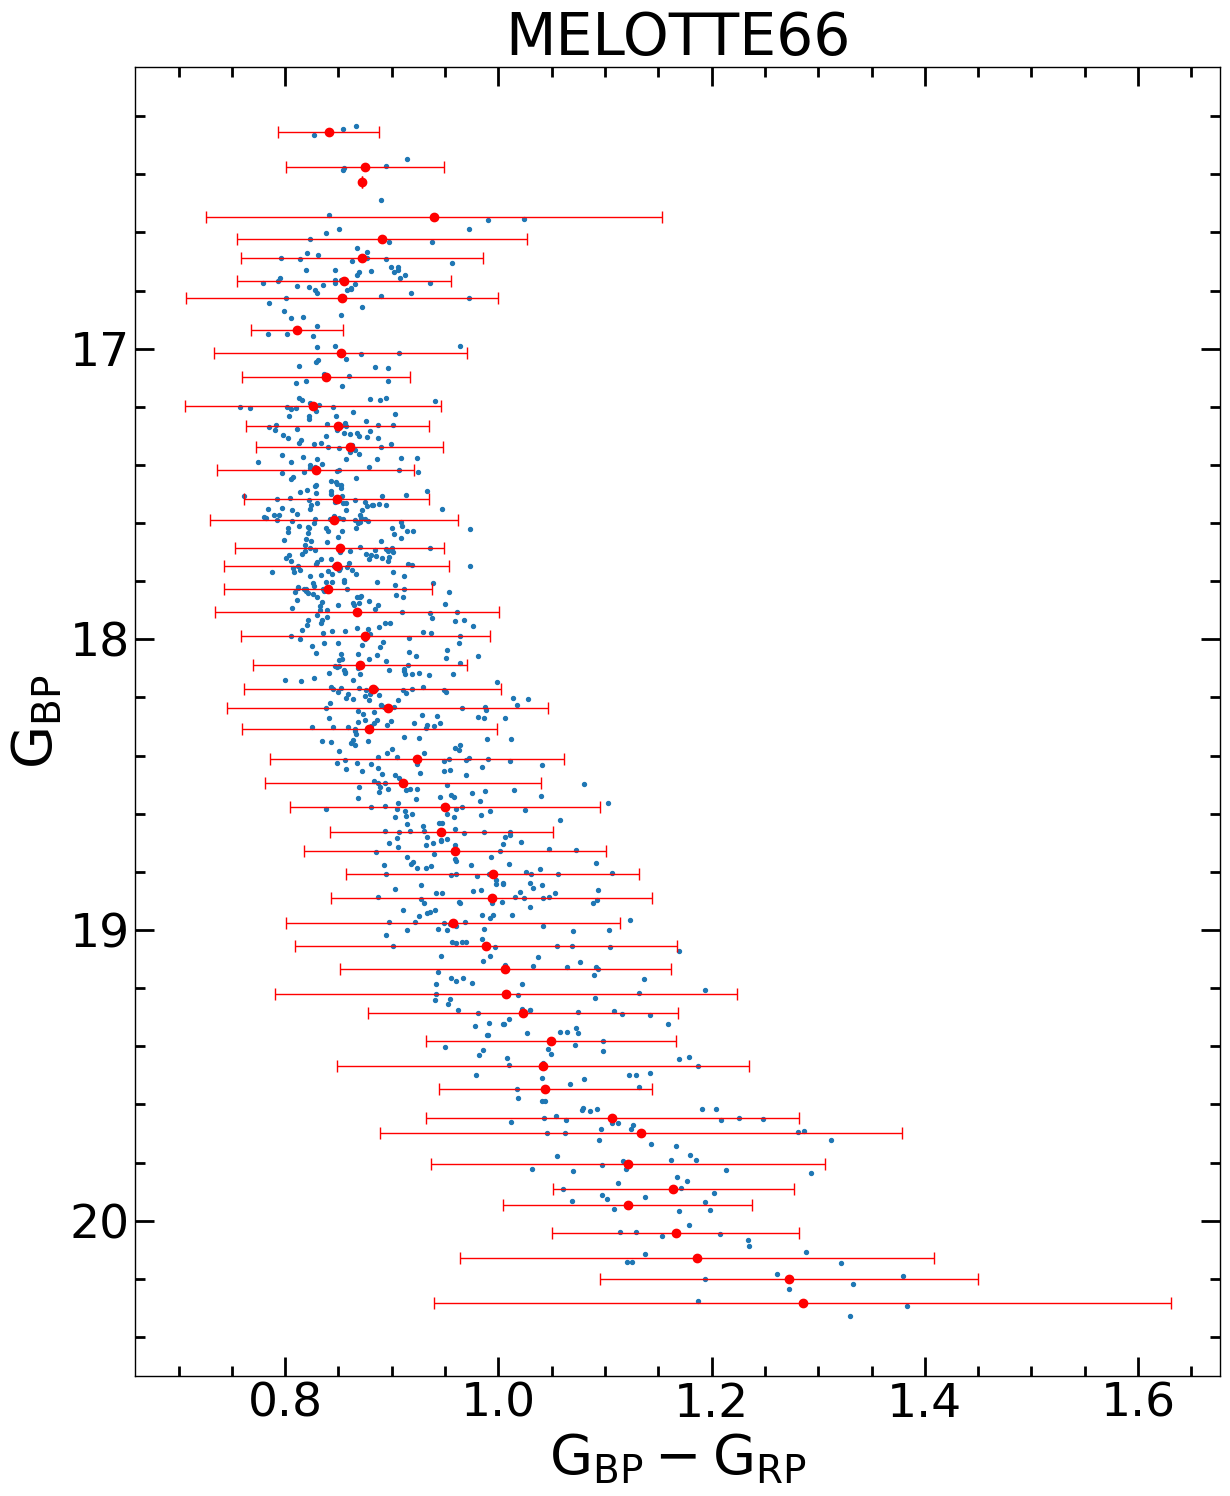

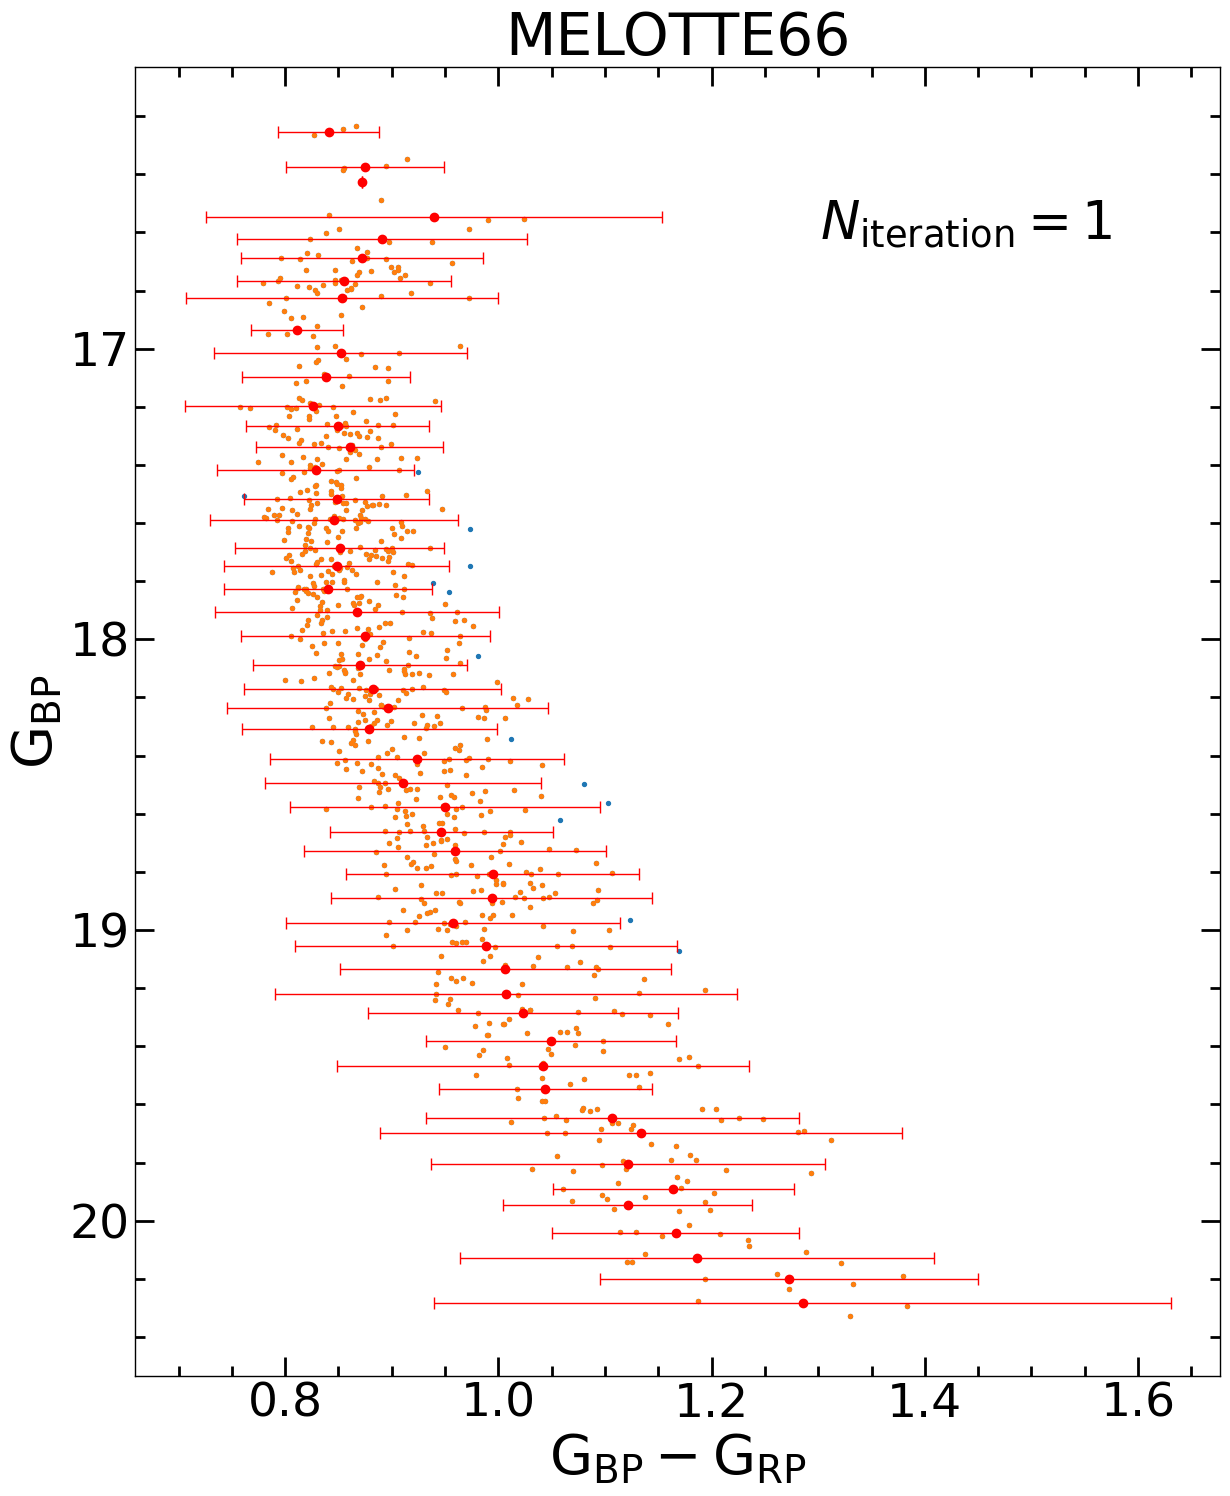

[*] Building bins...
[+] Bins created: 50
[*] Cleaning bins...
[*] Bins cleaned


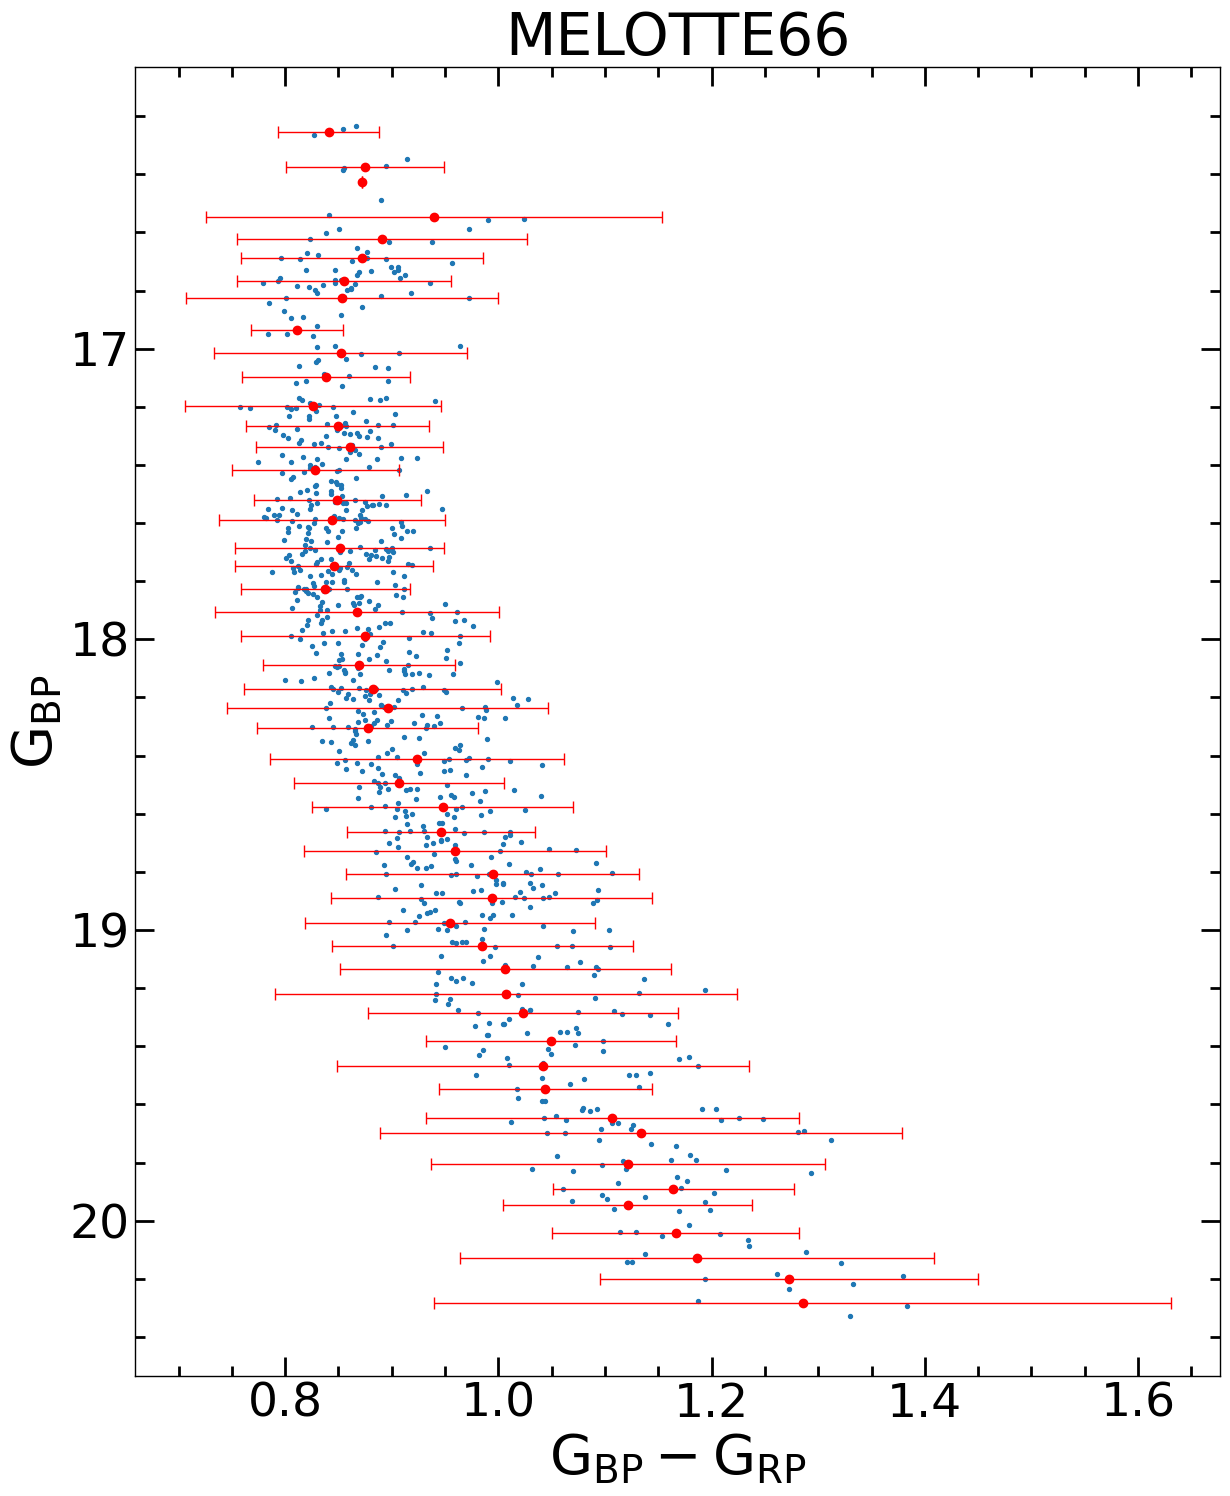

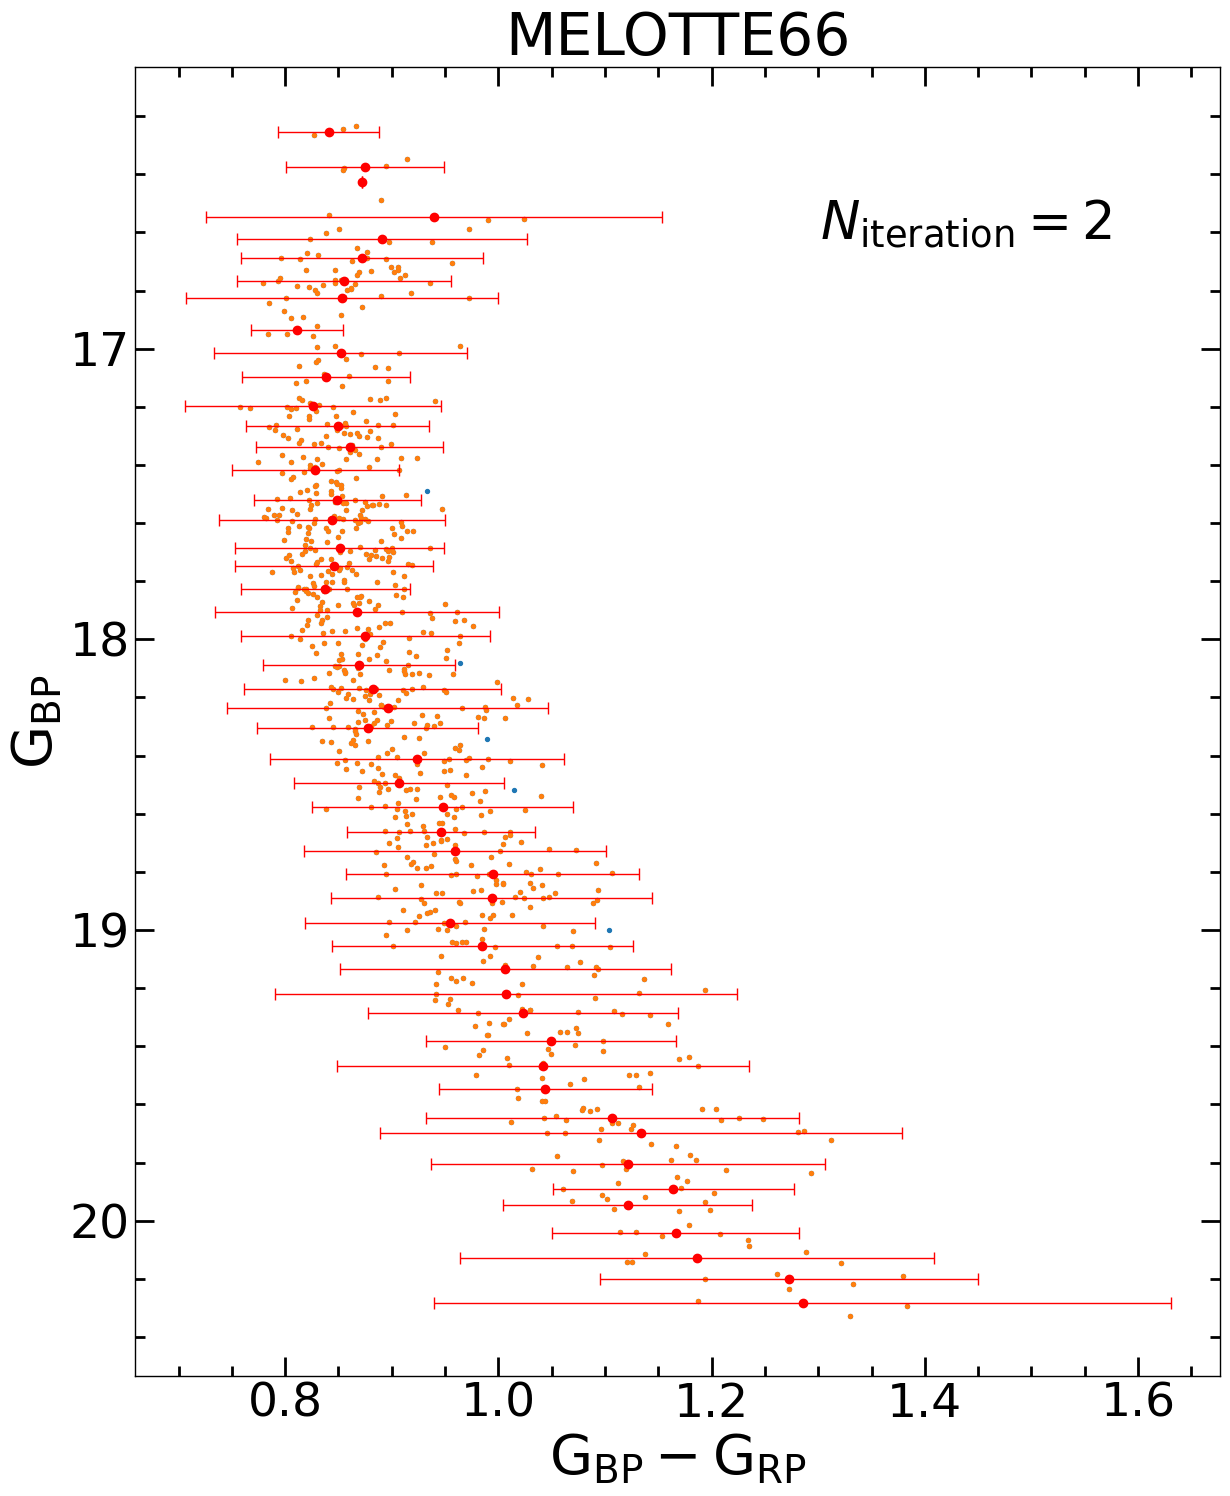

[*] Building bins...
[+] Bins created: 50
[*] Cleaning bins...
[*] Bins cleaned


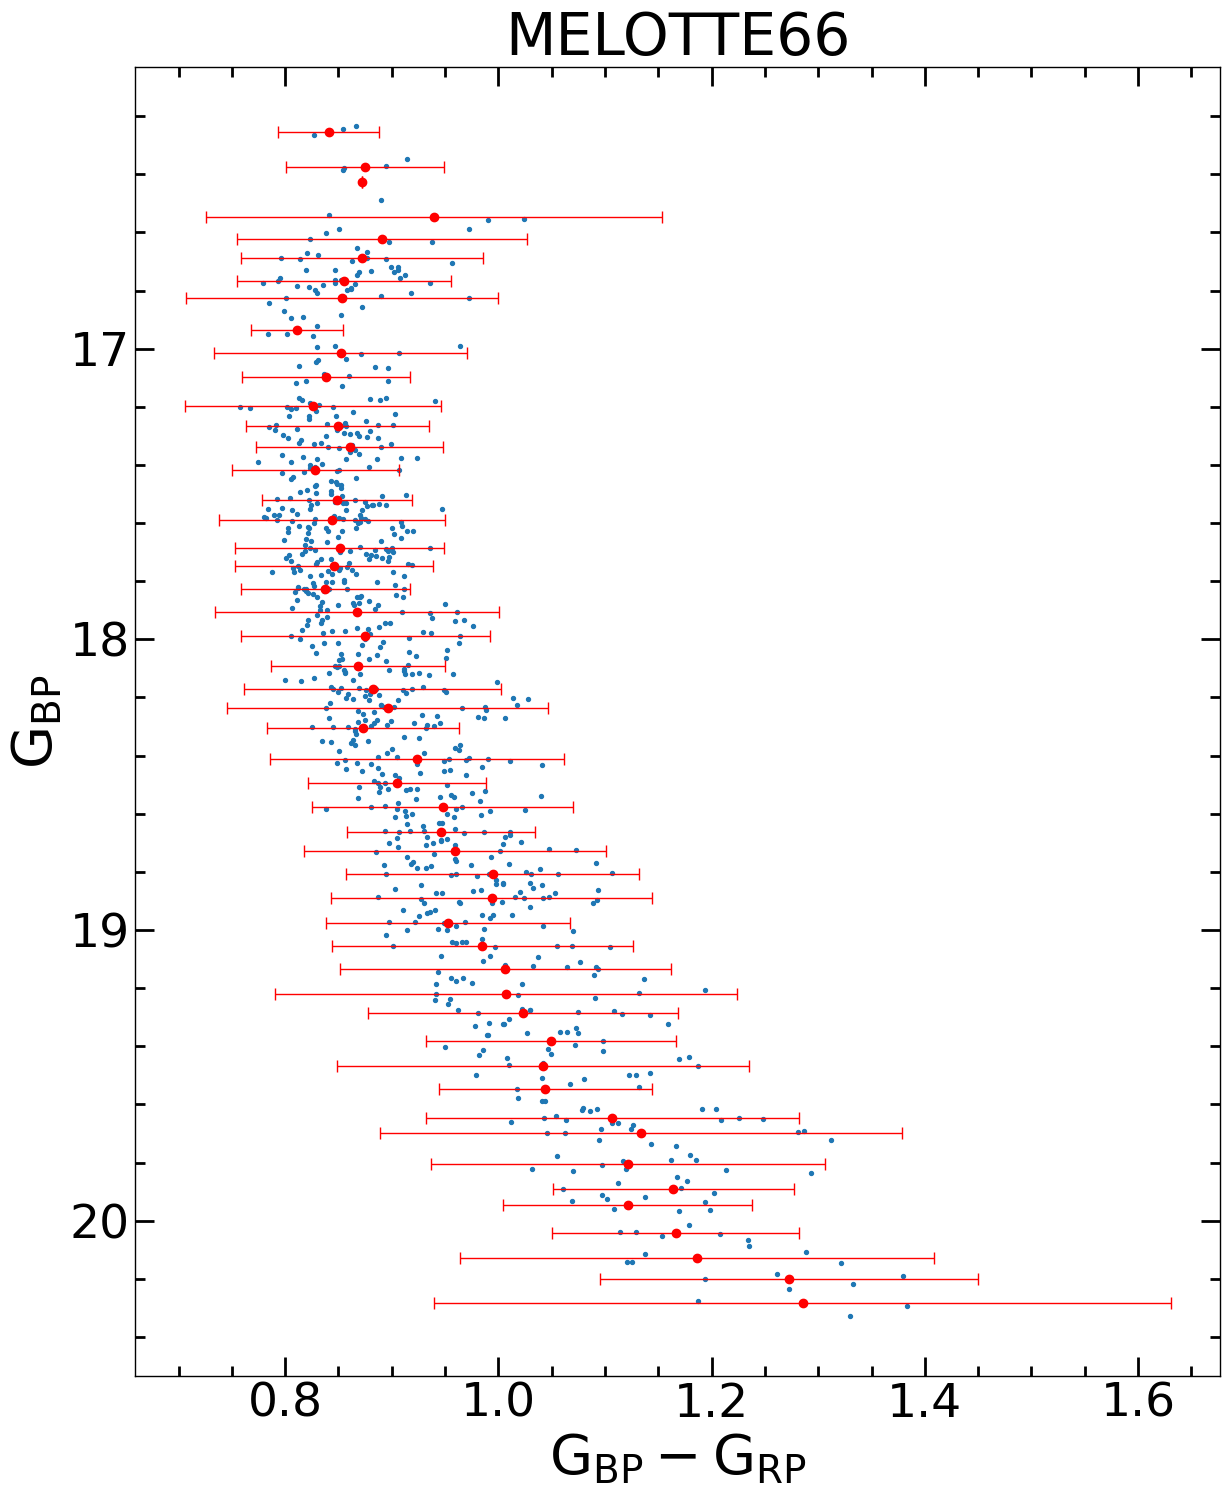

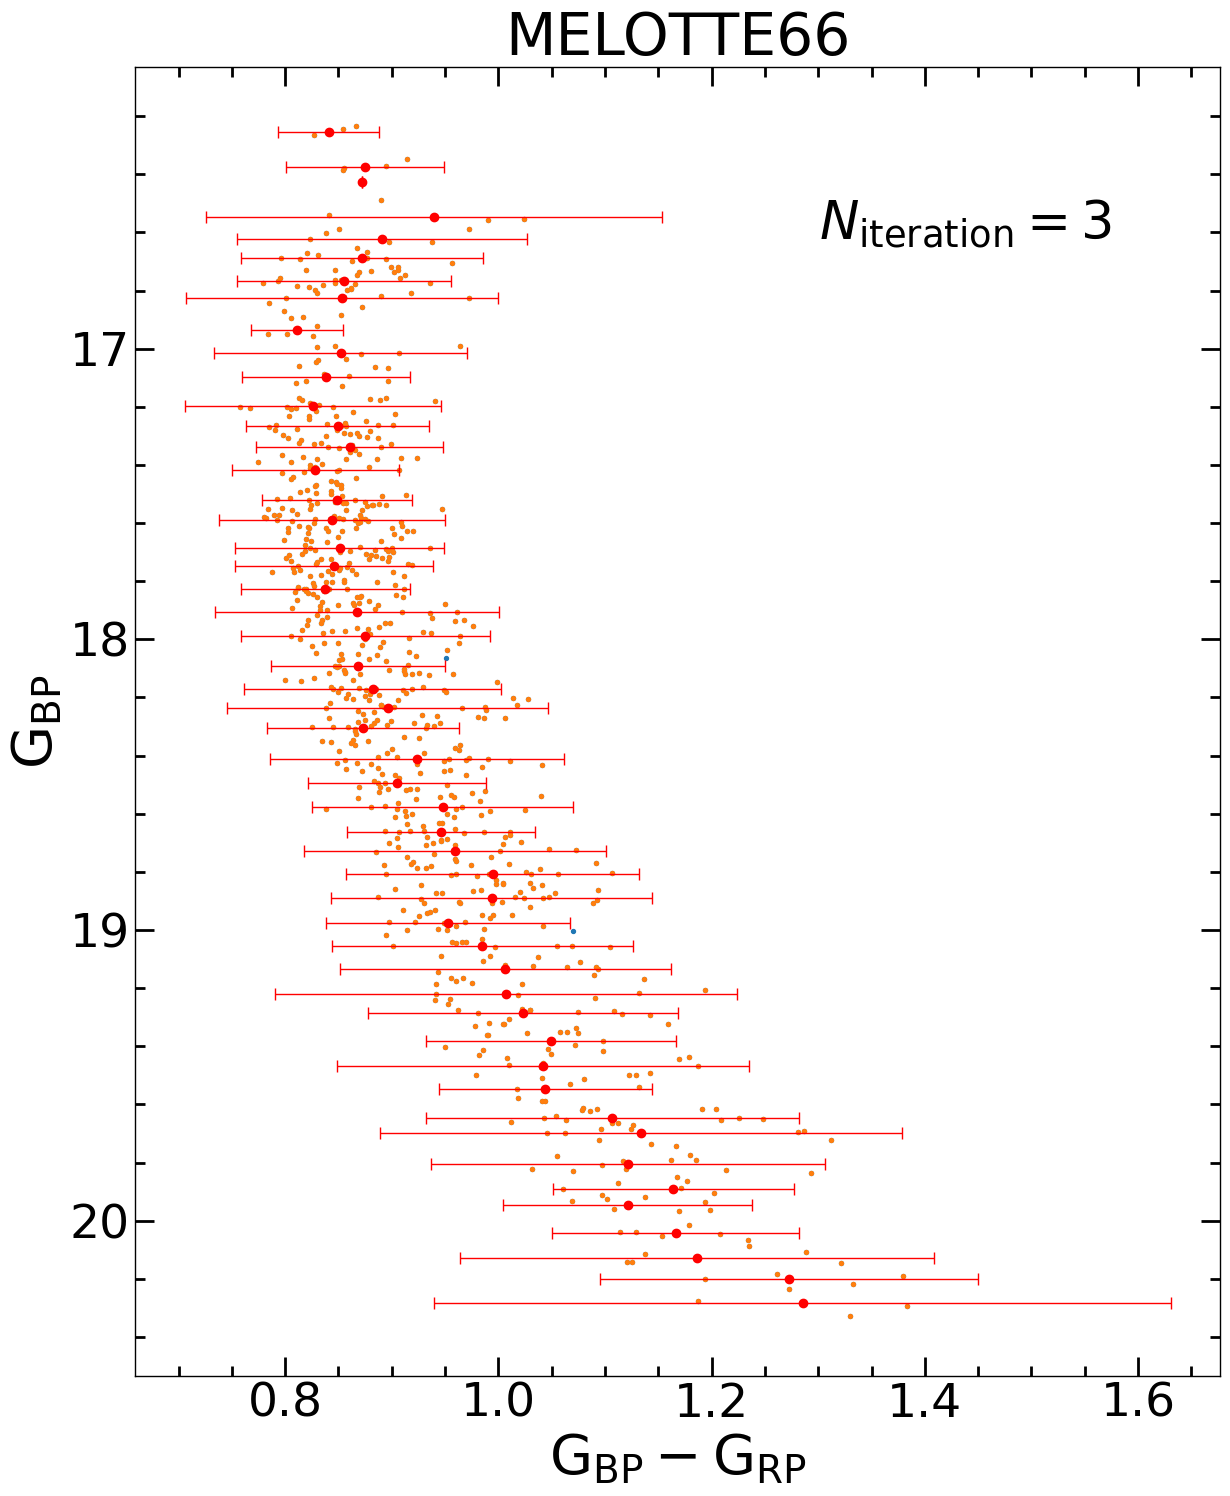

[*] Building bins...
[+] Bins created: 50
[*] Cleaning bins...
[*] Bins cleaned


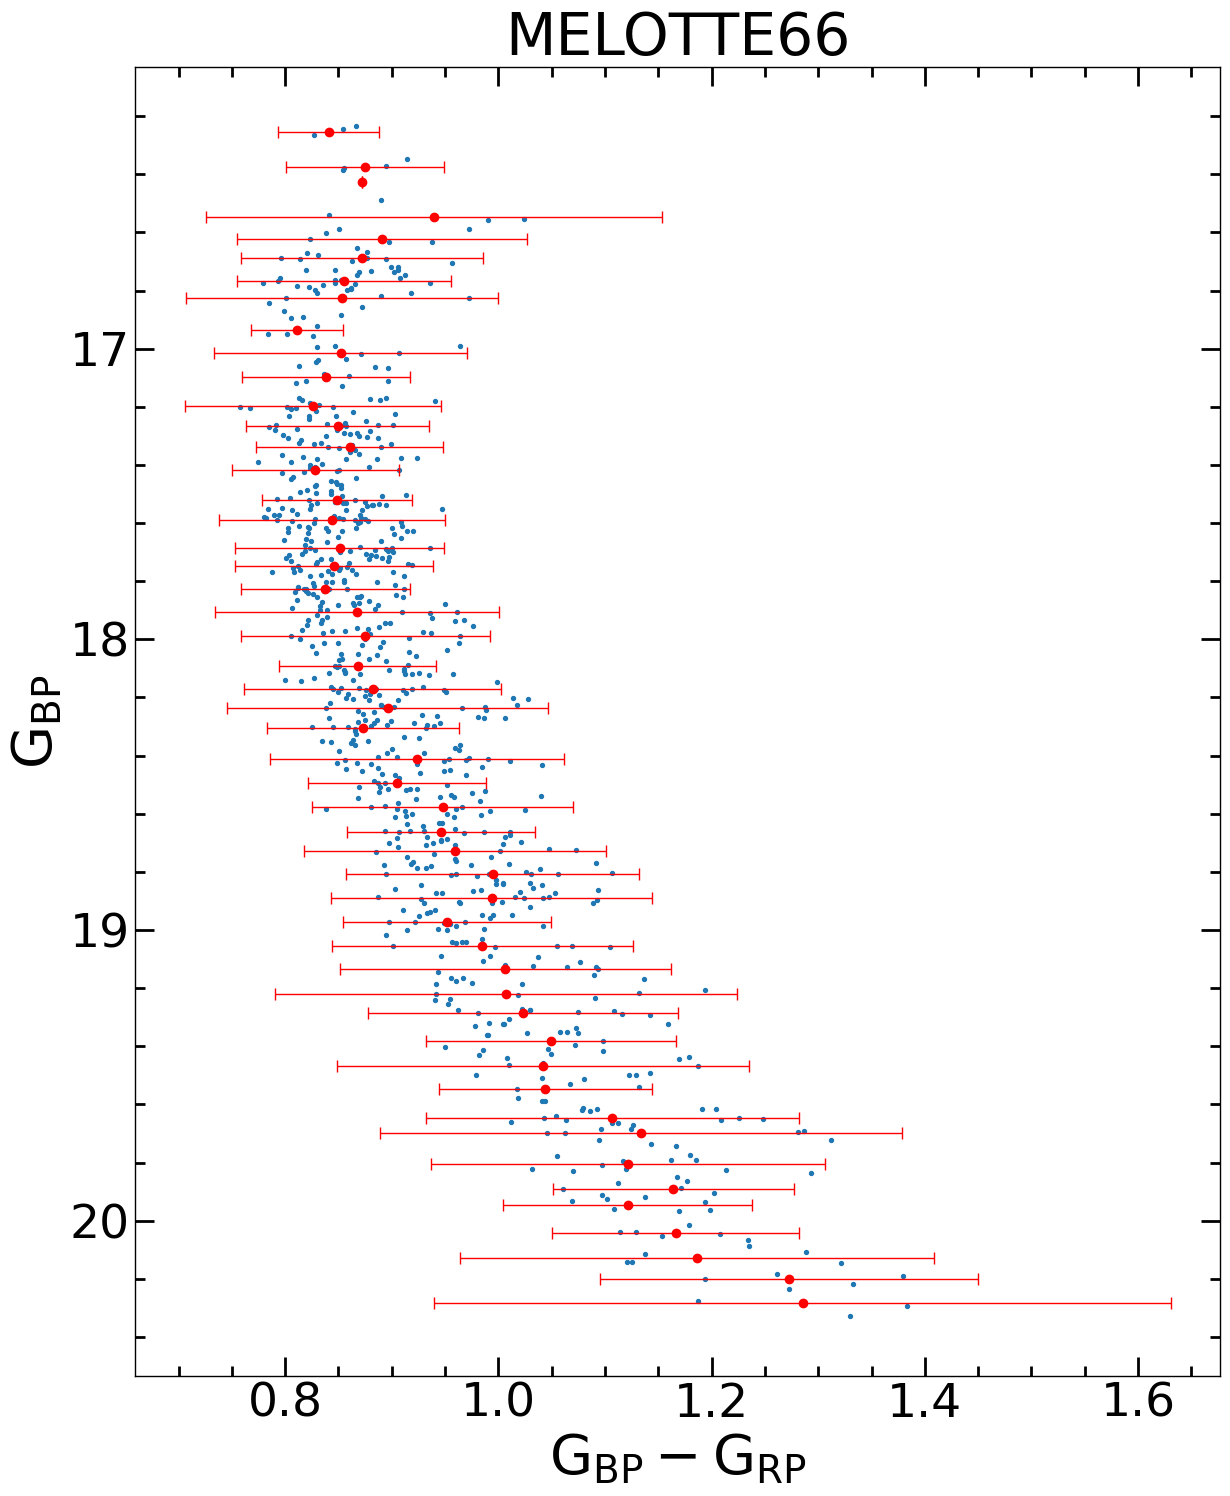

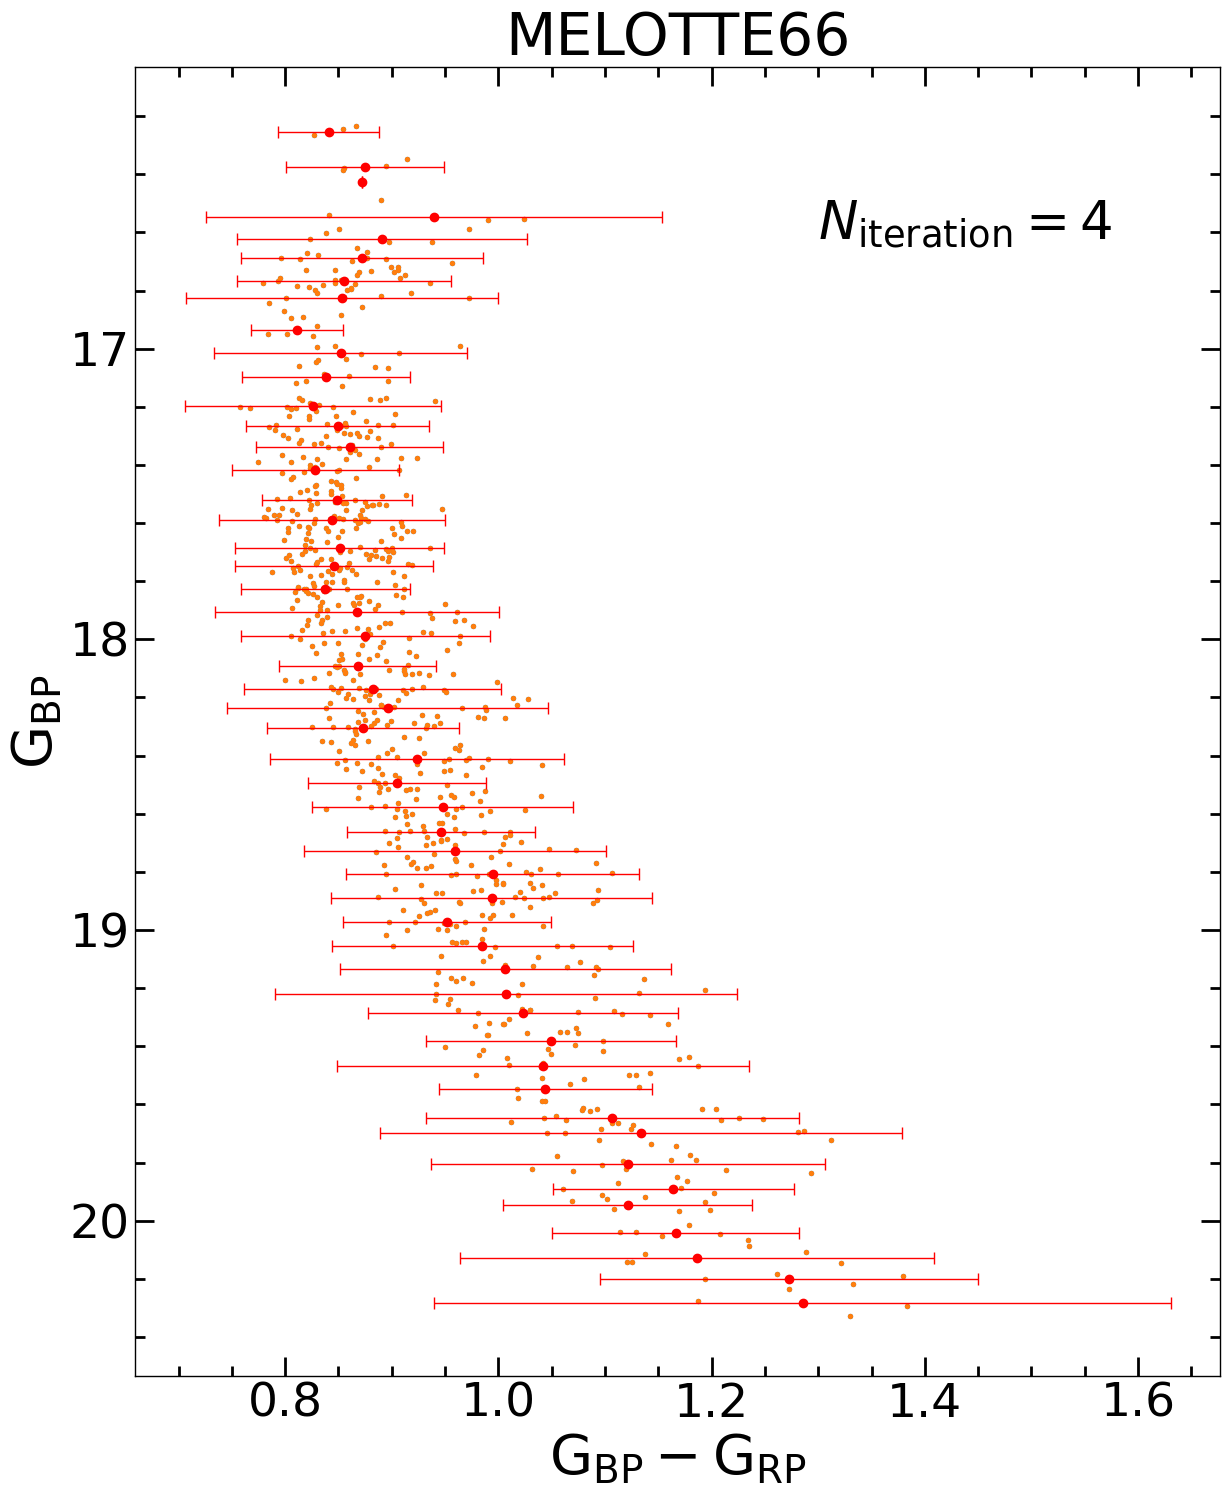

[*] Building bins...
[+] Bins created: 50
[*] Cleaning bins...
[*] Bins cleaned


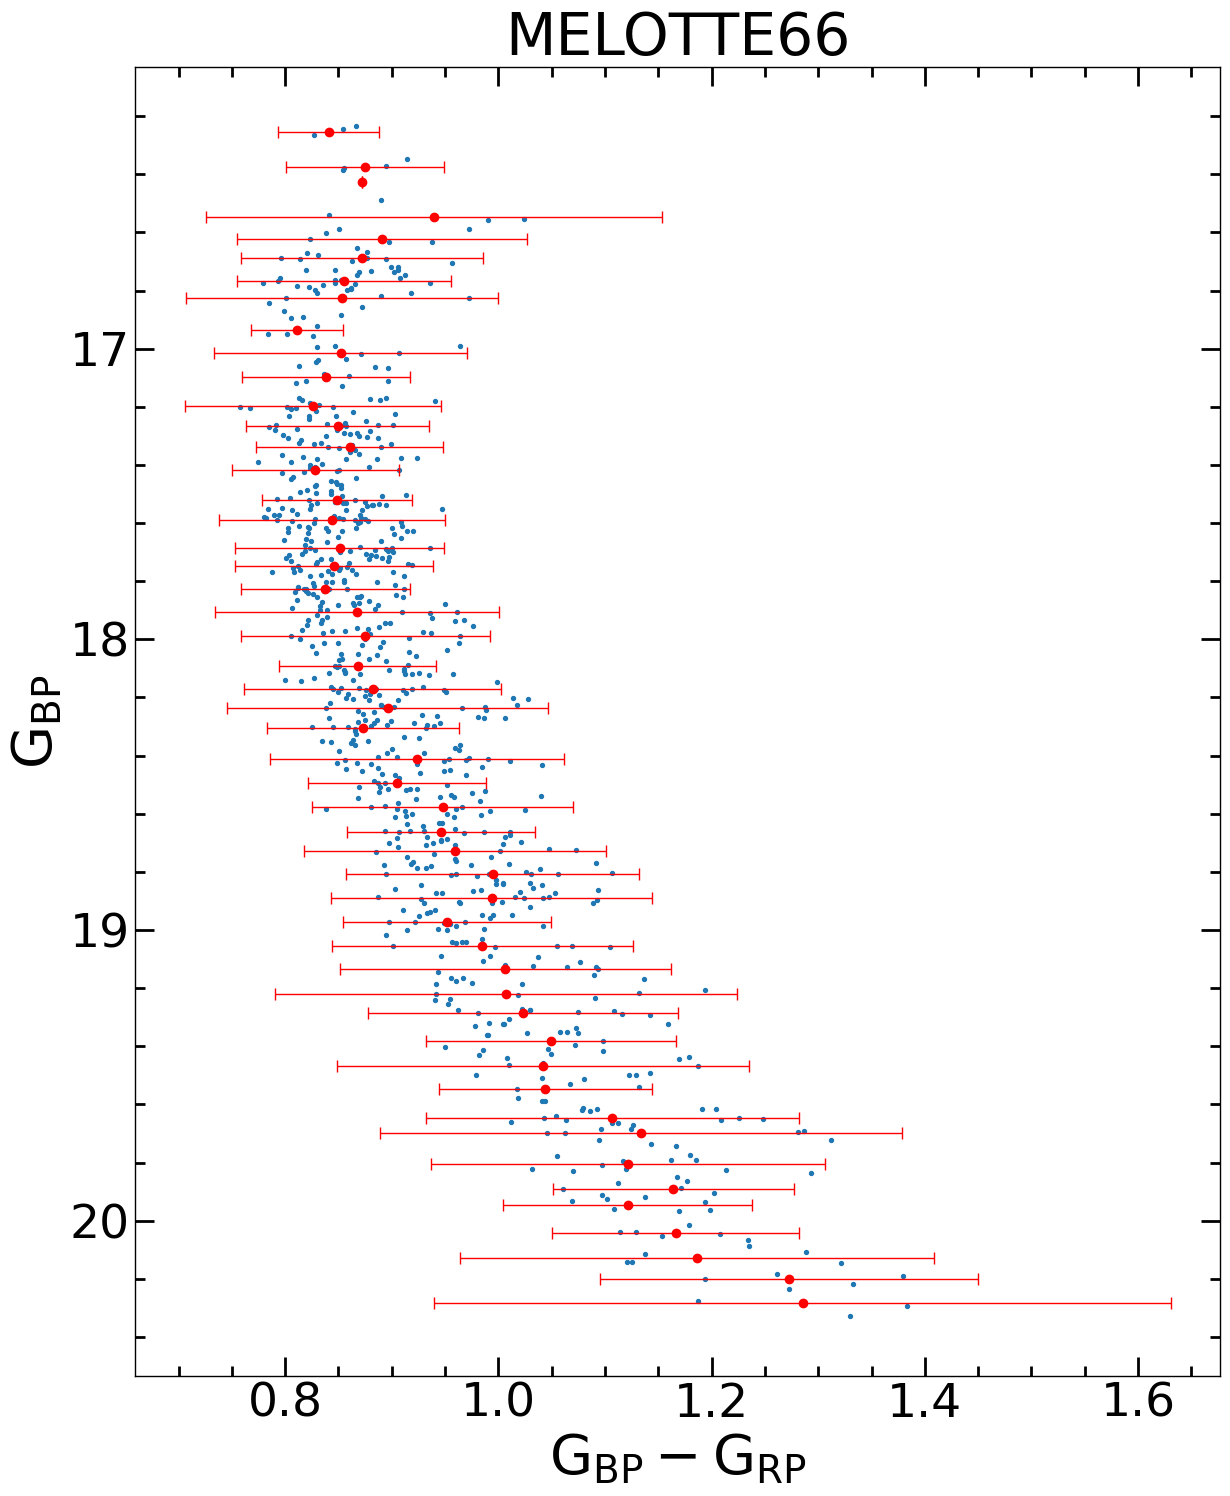

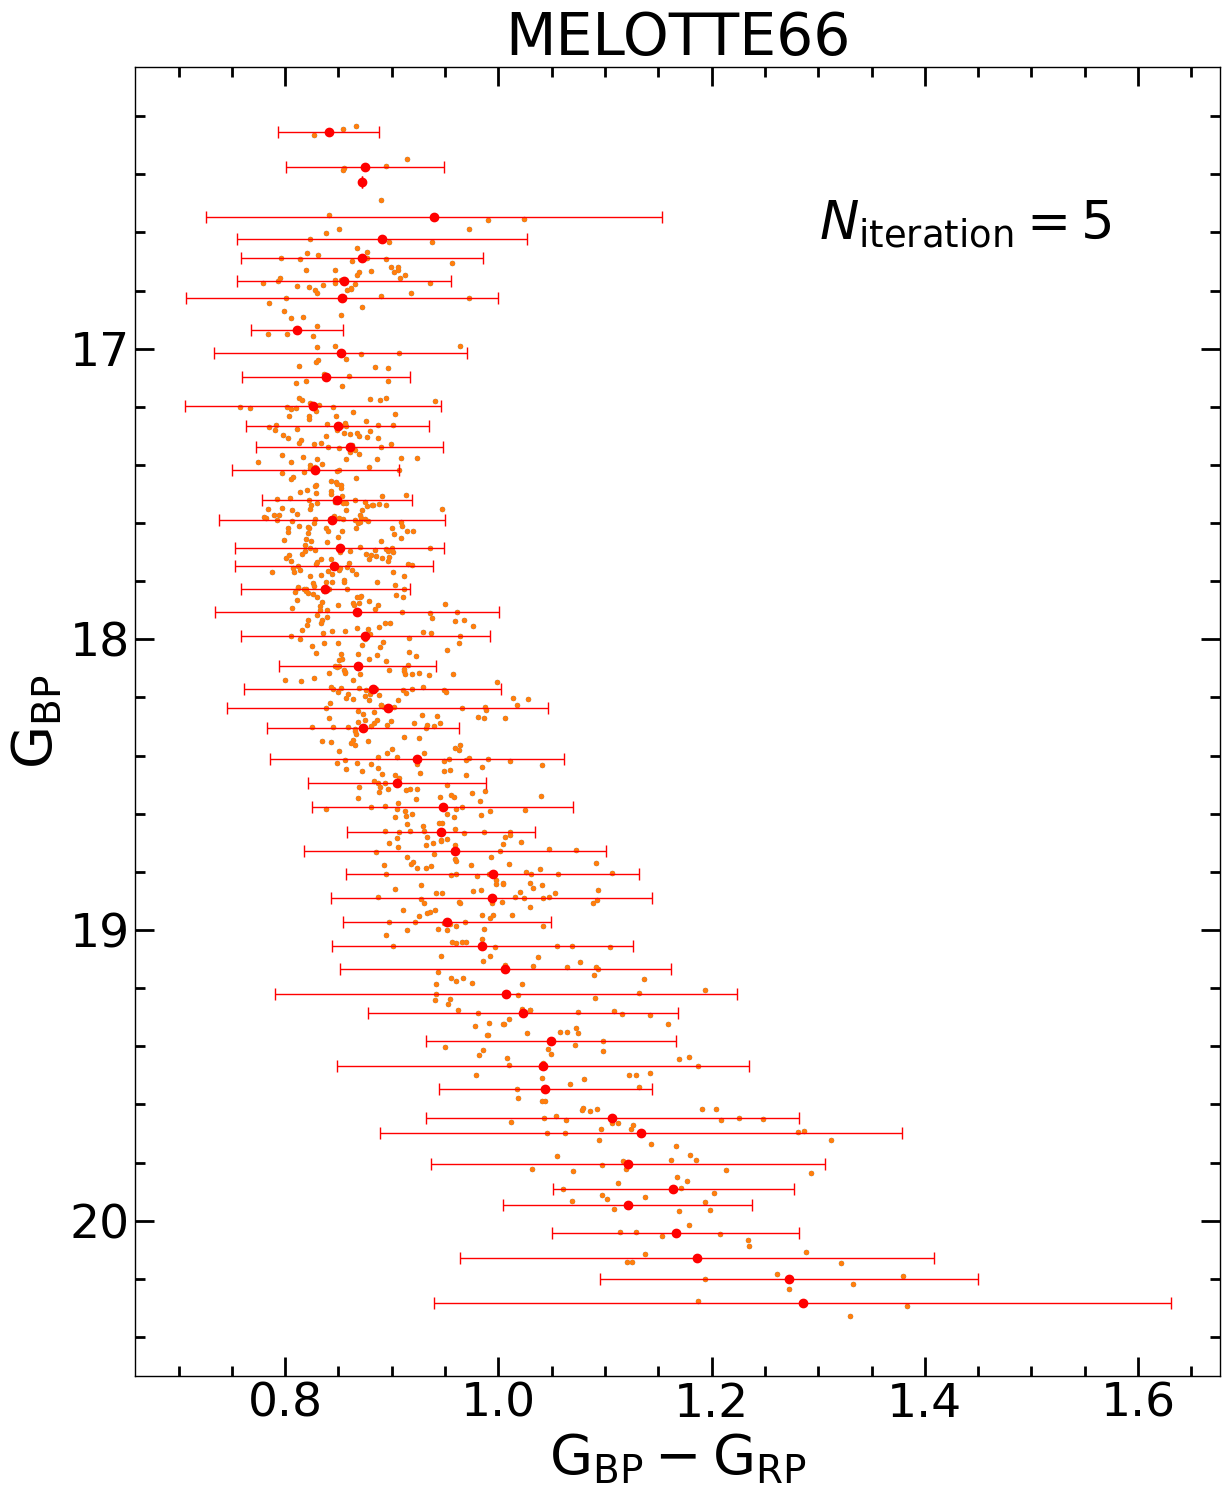

[*] Building bins...
[+] Bins created: 50
[*] Cleaning bins...
[*] Bins cleaned


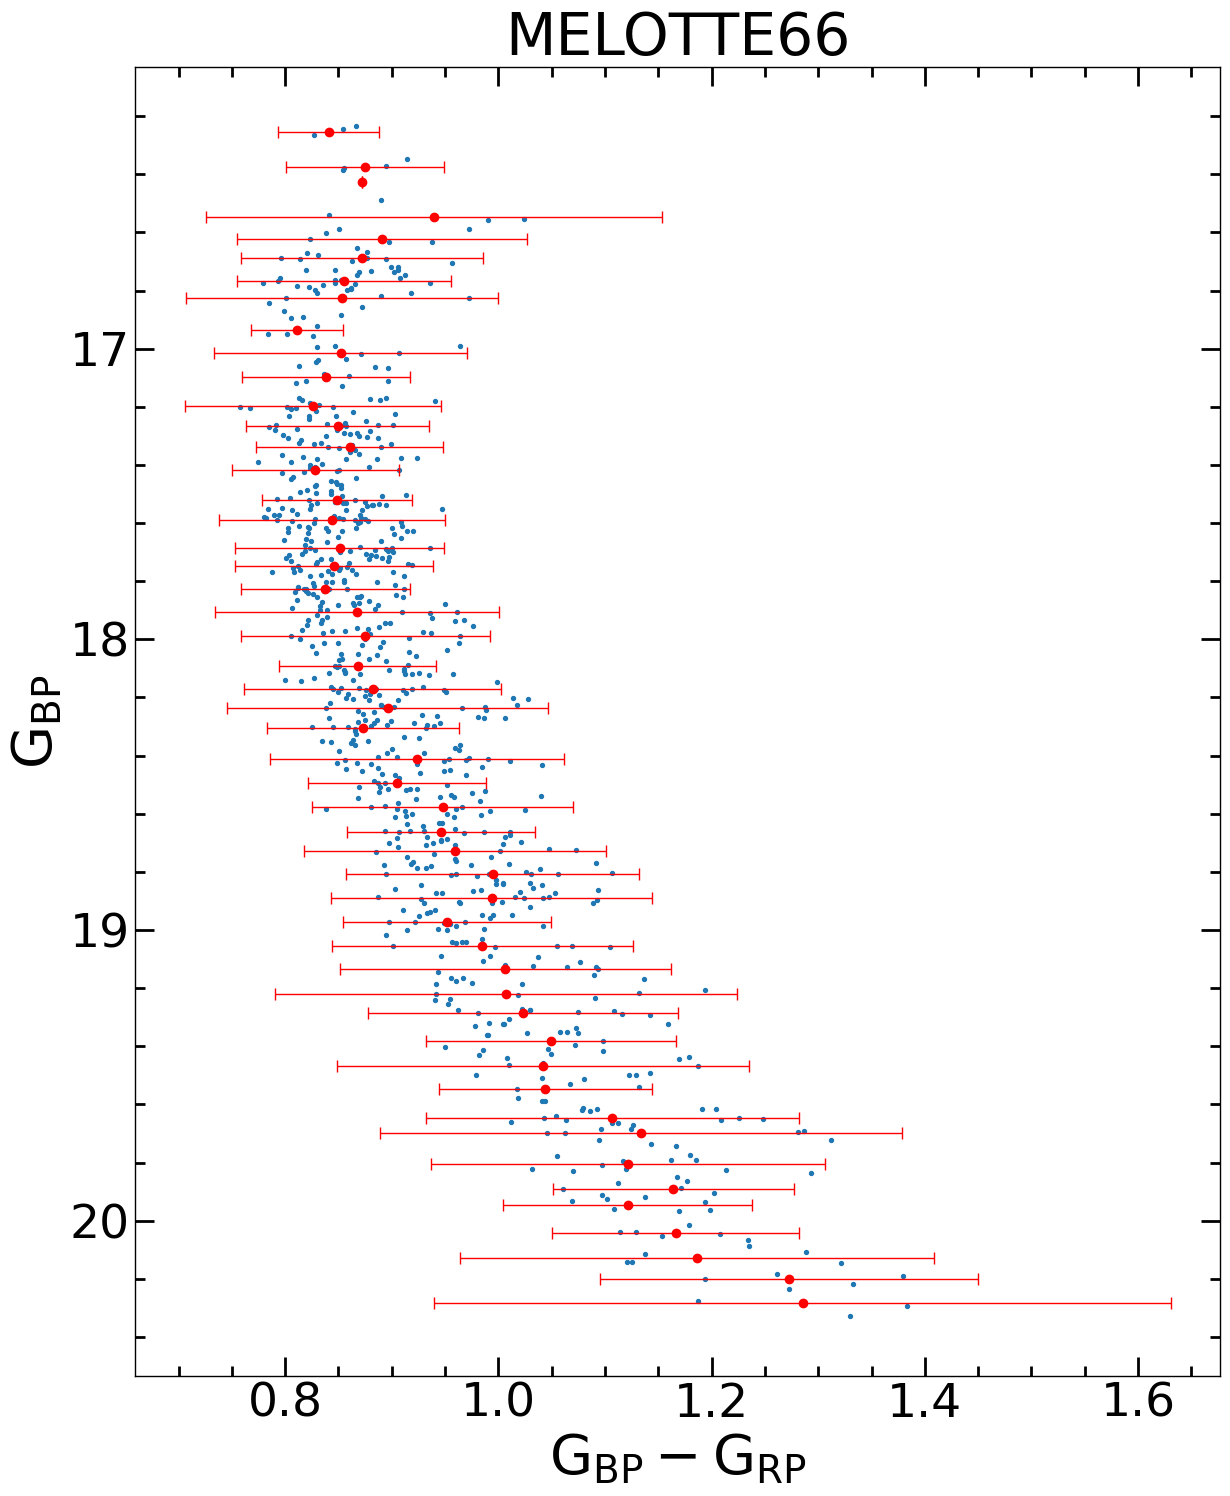

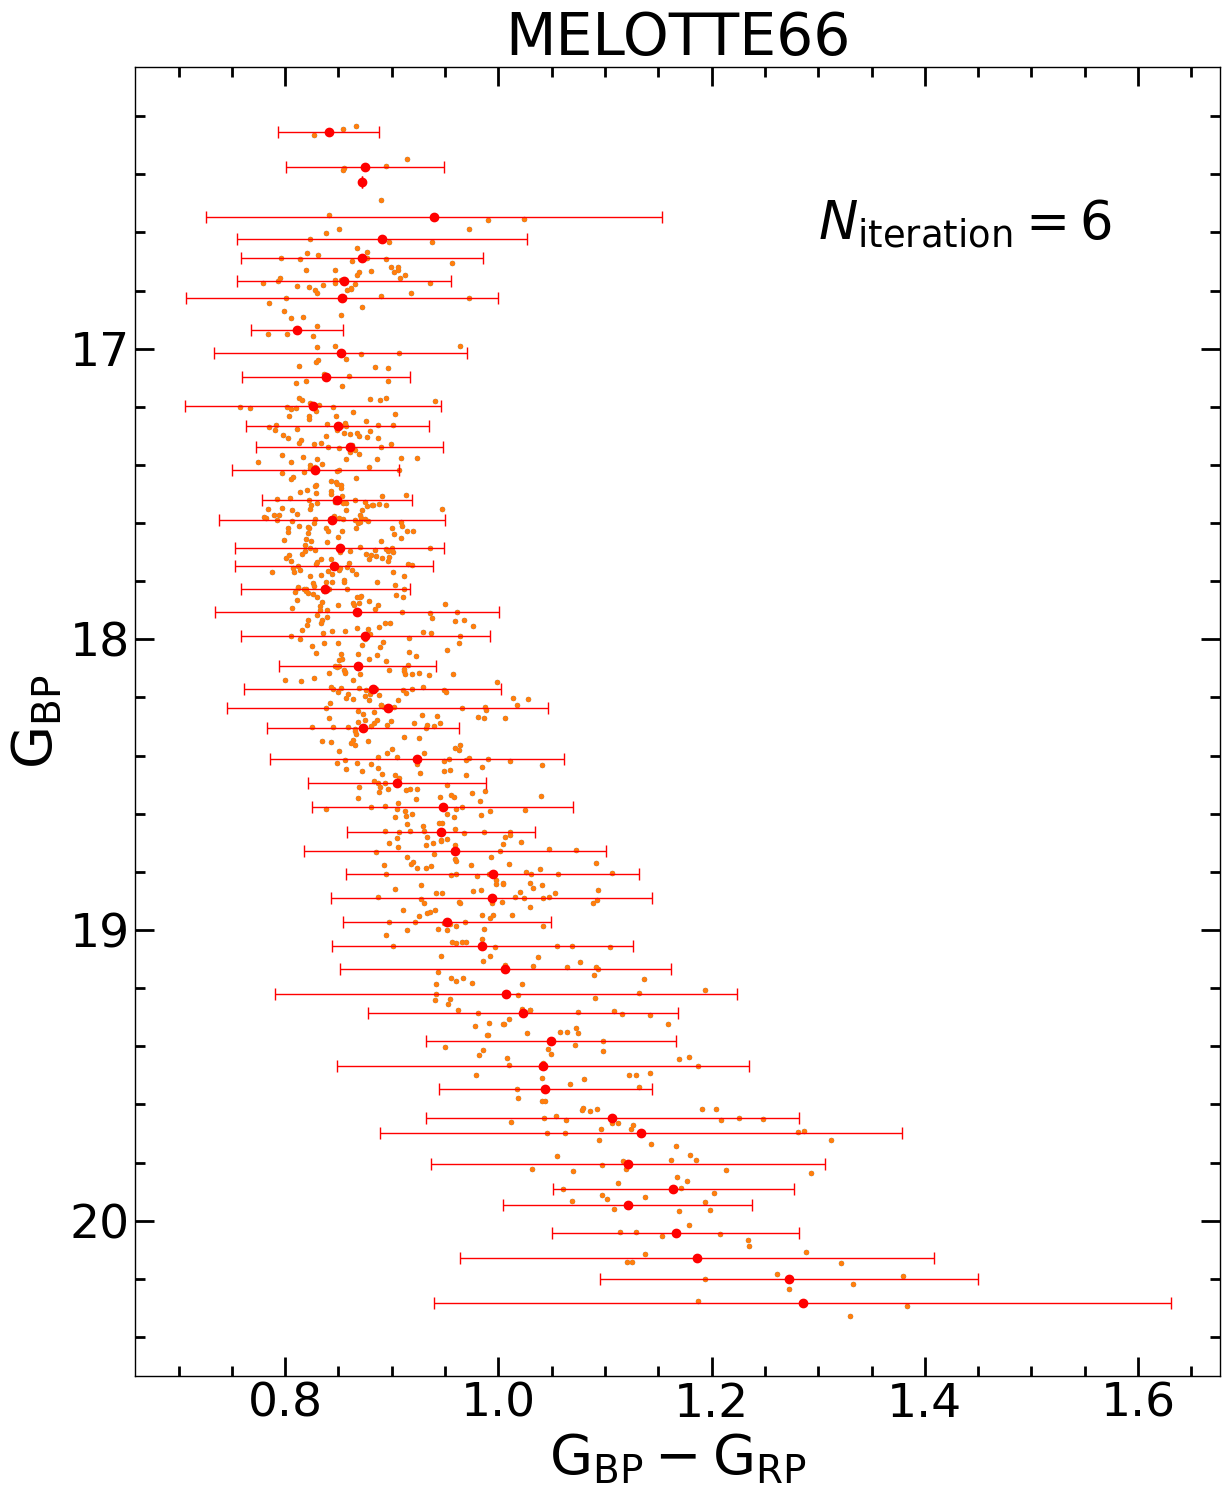

In [7]:
def GetRidgeLine(n_steps: int = n_iteration_steps):
    for iteration in range(1, n_iteration_steps+1):
        if iteration == 1:
            data = Table.read(file_containing_data, format=format_to_read_data)  
            data.pprint(max_lines=5, max_width=120)
        else:
            data = data_cleaned
        bins_list = build_bins(data, parameter_magnitude, parameter_color)
        data_cleaned = clean_bins(data, "phot_bp_mean_mag", "bp_rp", bins_list)
        plot_original_bins_in_CMD(data, "bp_rp", "phot_bp_mean_mag", bins_list, doSaveimage=False)
        plot_cleaned_ridge_line(data, data_cleaned, "bp_rp", "phot_bp_mean_mag", bins_list, iteration)
    return data_cleaned
        
data_cleaned = GetRidgeLine()

## Find Turn-off point (if available)

Use the ridge line to find the Main-Sequence Turn-Off (MSTO) point.

- Interpolate a simple linear function between every dot of the ridge line
- Get the inclination
- When the inclination changes from negative to positive, there you should have your MSTO point

[+] Possible MSTO values:
    elem number '1' -- MSTO color 0.841 -- MSTO std_color 0.019 -- MSTO mag 16.255
    elem number '2' -- MSTO color 0.872 -- MSTO std_color 0.000 -- MSTO mag 16.426
    elem number '3' -- MSTO color 0.811 -- MSTO std_color 0.017 -- MSTO mag 16.936
    elem number '4' -- MSTO color 0.826 -- MSTO std_color 0.048 -- MSTO mag 17.196
    elem number '5' -- MSTO color 0.849 -- MSTO std_color 0.034 -- MSTO mag 17.265
    elem number '6' -- MSTO color 0.828 -- MSTO std_color 0.037 -- MSTO mag 17.419
    elem number '7' -- MSTO color 0.846 -- MSTO std_color 0.046 -- MSTO mag 17.591
    elem number '8' -- MSTO color 0.840 -- MSTO std_color 0.039 -- MSTO mag 17.828
    elem number '9' -- MSTO color 0.867 -- MSTO std_color 0.053 -- MSTO mag 17.907
    elem number '10' -- MSTO color 0.870 -- MSTO std_color 0.040 -- MSTO mag 18.087
    elem number '11' -- MSTO color 0.882 -- MSTO std_color 0.048 -- MSTO mag 18.170
    elem number '12' -- MSTO color 0.879 -- MSTO std_color 

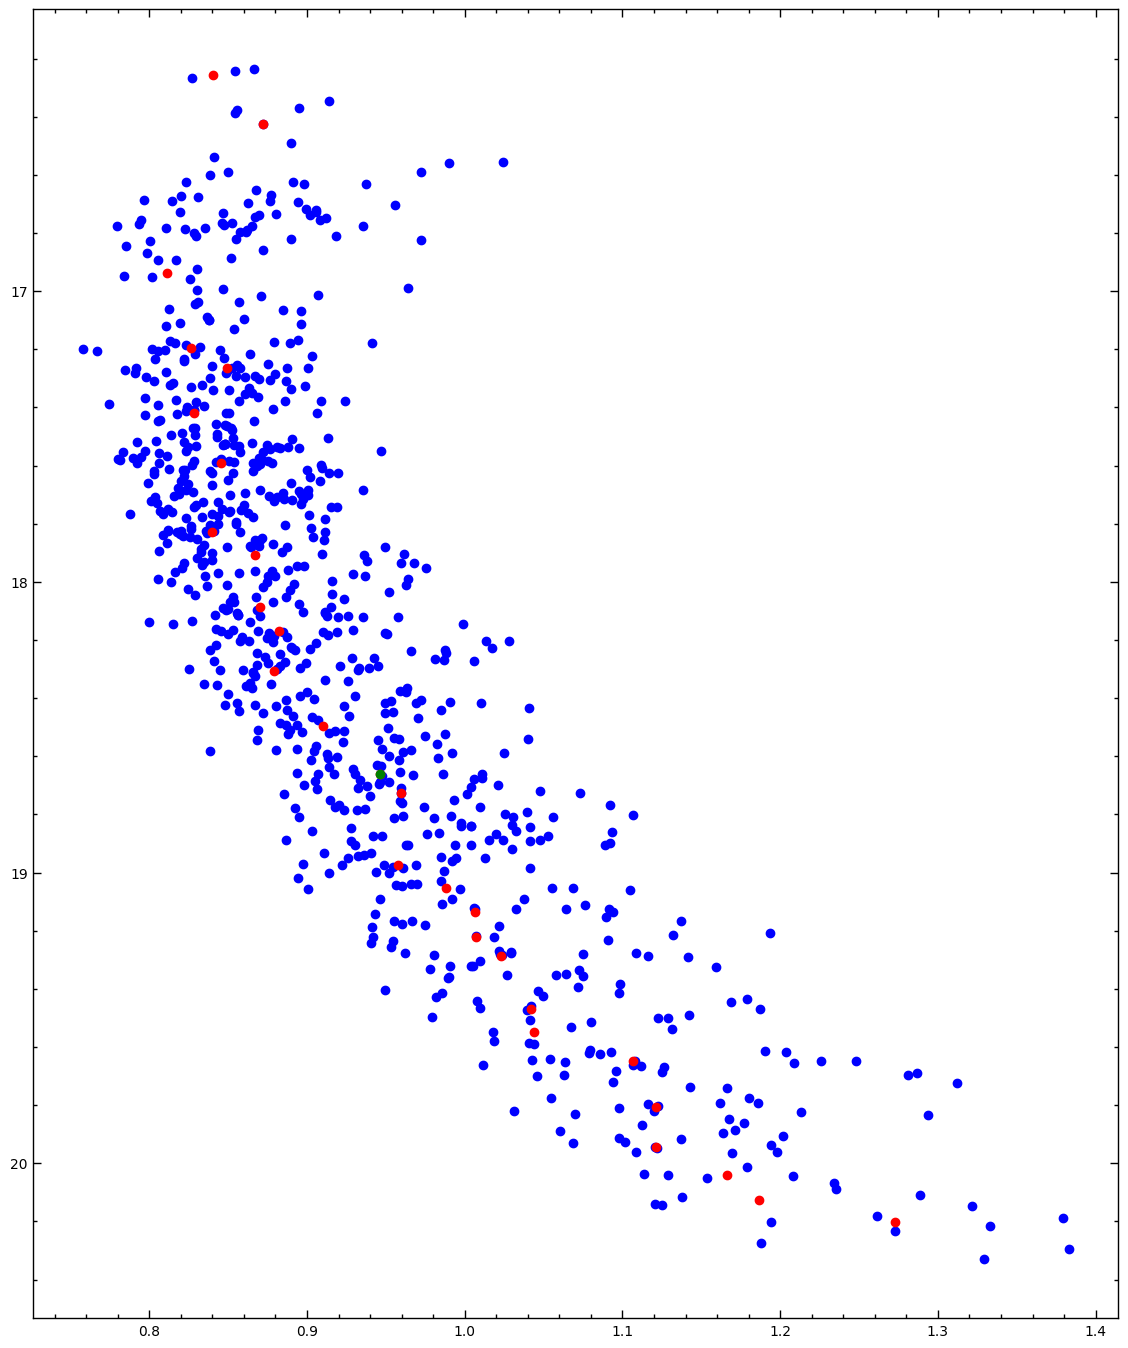

In [8]:
@dataclass(frozen=True, kw_only=True)
class RidgeLinePoint:
    color_coord: float # x-axis
    mag_coord: float   # y-axis
    std_color: float   # rms color of the bin
        
        
def get_RidgeLine_object(bins_list_var: list[classBin]) -> list[RidgeLinePoint] | None:
    ridge_line = []
    for bins_it in bins_list_var:
        point = RidgeLinePoint(color_coord=bins_it.median_color_value,
                               mag_coord=bins_it.median_mag_value,
                               std_color=bins_it.std_color)
        ridge_line.append(point)
    if len(ridge_line) != len(bins_list_var):
        print(f"[!] Ridge line and bins do not have the same length: {len(ridge_line)} and {len(bins_list_var)}, respectively")
        sys.exit(1)
    return ridge_line


def get_MainSequence_TurnOff_pont(ridgeline_list: list[RidgeLinePoint], 
                                  select: NoneType | int = None) -> RidgeLinePoint | None:
    """
    Get the MSTO point based on the inclination 
    """
    possible_MSTO_points = []
    for j in range(0, len(ridgeline_list)-1):
        # Find the slope (m) and y-intercept (c)
        color_points = np.asarray([ridgeline_list[j].color_coord, ridge_line[j+1].color_coord]) # x
        mag_points = np.asarray([ridgeline_list[j].mag_coord, ridgeline_list[j+1].mag_coord]) # y
        try:
            m, c = np.polyfit(color_points, mag_points, 1) # find y = m*x +c
        except np.linalg.LinAlgError:
            m, c = -1, -1
        if m > 0: # if we have a positive inclination
            possible_MSTO_points.append(ridgeline_list[j])
    if len(possible_MSTO_points) == 0:
        print("[-] No MSTO point found")
        return
    if len(possible_MSTO_points) == 1:
        return possible_MSTO_points[0]
    if len(possible_MSTO_points) > 1:
        print("[+] Possible MSTO values:")
        for index, possible_points in enumerate(possible_MSTO_points):
            print(f"    elem number '{index+1}' -- MSTO color {possible_points.color_coord:.3f} -- MSTO std_color {possible_points.std_color:.3f} -- MSTO mag {possible_points.mag_coord:.3f}")
        plt.figure(figsize=(14, 17))
        plt.gca().invert_yaxis()
        plt.plot(data_cleaned[parameter_color], data_cleaned[parameter_magnitude], 'bo')
        plt.plot([point.color_coord for point in possible_MSTO_points], [point.mag_coord for point in possible_MSTO_points], 'ro')
        if select is not None:
            plt.plot(possible_MSTO_points[int(-1.0*select)].color_coord, possible_MSTO_points[int(-1.0*select)].mag_coord, 'go')
        if select is None:
            return possible_MSTO_points[0]
        else:
            # If we set "select" to "1", it will return the first element/possible MSTO point and so on...
            return possible_MSTO_points[int(-1.0*select)]
    
        
ridge_line = get_RidgeLine_object(bins_list)
MSTO_point = get_MainSequence_TurnOff_pont(ridge_line, select=15)
print(f"MSTO: ({MSTO_point.color_coord:.3f} ± {MSTO_point.std_color:.3f}, {MSTO_point.mag_coord:.3f})")

## Add the MSTO point found to a file for future purposes

In [9]:
new_data = f"{object_name.lower()} {MSTO_point.color_coord:.3f} {MSTO_point.std_color:.3f} {MSTO_point.mag_coord:.3f}"
print(f"MSTO: ({MSTO_point.color_coord:.3f} ± {MSTO_point.std_color:.3f}, {MSTO_point.mag_coord:.3f})")
if os.path.exists(file_to_write_results):
    user_input = input("Do you want to write the results? (yes/no): ")
    if re.match(r'^\s*(yes|y)\s*$', user_input, re.IGNORECASE):
        with open(file_to_write_results, 'a') as file:
            file.write(new_data+'\n')
else:
    # File doesn't exist
    with open(file_to_write_results, 'w') as file:
        file.write("# name MSTO_color MSTO_std_color MSTO_mag\n")
        file.write(new_data+'\n')

MSTO: (0.946 ± 0.042, 18.661)
Do you want to write the results? (yes/no): n
